# Machine Learning Project - Classify Images of Road Traffic Signs

## Data Preprocessing

* We create the dataset by extracting the image paths, shapes and their types and store them in three different columns.
* The correct classification of the images is given by the image sub-directories.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [170]:
import os
import csv

def extract_path(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png')): # Find images that end with png
                image_files.append(os.path.join(root, file)) # Append the image path into a list
    return image_files

def imgpath_toCsv(imgPaths, csv_file):
    with open(csv_file, 'w', newline='') as file:
        csvWriter = csv.writer(file)
        for path in imgPaths: # Extract shape and type based on the image path
            shape = path.split(os.path.sep)[1] # Extract the Shape (it's in the first column if seperate the path by '\')
            sign_type = path.split(os.path.sep)[2] # Extract the Type (it's in the second column if seperate the path by '\')
            csvWriter.writerow([path, shape, sign_type]) # Write three columns into csv

imgPaths = extract_path("./trafficsigns_dataset/trafficsigns_dataset") # German TSC dataset
imgpath_toCsv(imgPaths, "s3819792.csv")

imgPaths_ind = extract_path("./s3819792/trafficsigns_dataset") # Independent German TSC dataset
imgpath_toCsv(imgPaths_ind, "s3819792_idptest.csv")

## Reading Data

* The independent dataset consists of 466 images which were collected online (Traore, 2022).
* Our training dataset consists of 2219 images, so we need at least 20% of the training set, i.e., 444 images, as an independent test dataset.
* We pre-processed the images by zooming in or cropping the traffic signs out manually.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
trafficsigns = pd.read_csv('./s3819792.csv', header=None)
trafficsigns = trafficsigns.rename(columns={0: 'ImgPath', 1: 'ShapeClass', 2: 'TypeClass'})
trafficsigns_test = pd.read_csv('./s3819792_idptest.csv', header=None)
trafficsigns_test = trafficsigns_test.rename(columns={0: 'ImgPath', 1: 'ShapeClass', 2: 'TypeClass'})

<b>Structure of the dataset:</b>

In [2]:
trafficsigns.head(2)

,ImgPath,ShapeClass,TypeClass
0,./trafficsigns_dataset/trafficsigns_dataset\di...,diamond,rightofway
1,./trafficsigns_dataset/trafficsigns_dataset\di...,diamond,rightofway


## Exploratory Data Analysis (EDA)

### Frequency graphs of Shape and Type

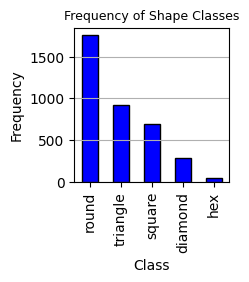

In [3]:
import matplotlib.pyplot as plt

shape_class = trafficsigns['ShapeClass'].value_counts()

plt.figure(figsize=(2, 2))
shape_class.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Shape Classes', fontsize = 9)
plt.grid(axis='y')
plt.show()


* From the Frequency graph of Shape classes above, we can notice most of the images in the dataset are in round shape.
* There are only a few images are in hex shape (no more than 100 images).
* Imbalanced classes in the dataset can introcude bias in the model's predictions and result in poor performance on the minority classes.

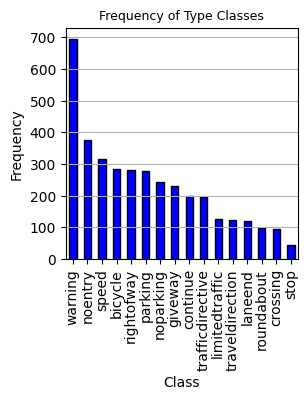

In [4]:
type_class = trafficsigns['TypeClass'].value_counts()

plt.figure(figsize=(3, 3))
type_class.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Type Classes', fontsize = 9)
plt.grid(axis='y')
plt.show()

* From the Frequency graph of Type classes above, we can notice most of the images in the dataset are in warning type.
* There are no more than 100 images are in roundabout, crossing and stop type.
* We need to be aware of imbalanced class issues in the dataset that can lead to biases in the model's predictions.

## Image Plot of Shape and Type

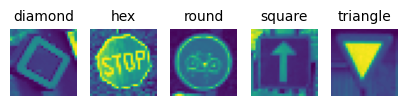

In [5]:
from PIL import Image

num_img = 5
plt.figure(figsize=(5,5))
class_indices = []
for class_label in trafficsigns['ShapeClass'].unique():
    class_index = trafficsigns[trafficsigns['ShapeClass'] == class_label].index[0] # Select the first index of each shape
    class_indices.append(class_index)

for i, idx in enumerate(class_indices):
    image_path = trafficsigns.loc[idx, 'ImgPath']
    image = Image.open(image_path)
    
    plt.subplot(1, 5, i + 1)
    plt.title(trafficsigns.loc[idx, 'ShapeClass'], fontsize = 10)
    plt.imshow(image)
    plt.axis('off')

plt.show()


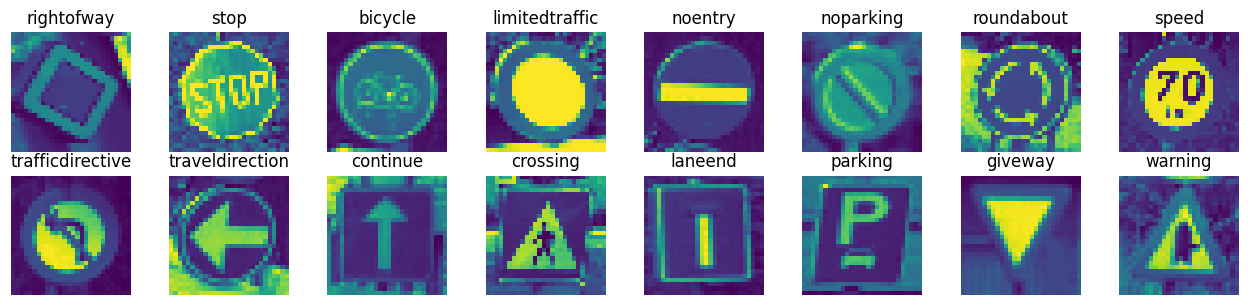

In [6]:
plt.figure(figsize=(16,9))
class_indices = []
for l in trafficsigns['TypeClass'].unique():
    class_index = trafficsigns[trafficsigns['TypeClass'] == l].index[0] # Select the first index of each type
    class_indices.append(class_index)

for i, idx in enumerate(class_indices):
    image_path = trafficsigns.loc[idx, 'ImgPath']
    image = Image.open(image_path)
    
    plt.subplot(5, 8, i + 1)
    plt.title(trafficsigns.loc[idx, 'TypeClass'], fontsize = 12)
    plt.imshow(image)
    plt.axis('off')

plt.show()


## Random splitting

We split the data into a 60/20/20 ratio for training, testing, and validation, respectively. 

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

OUTPUT_CLASSES_SHAPE = 5
OUTPUT_CLASSES_TYPE = 16
INPUT_DIM = (28,28,1) # Image Size

train_data, test_data = train_test_split(trafficsigns, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


## Shape Classification

### Baseline Model - Neural Network

* A simple Neural Network with only 3 layers was chosen as our baseline model.
* Neural Network is suitable for image classification task, it is able to learn features from the input images through the hidden layers.
* Neural Network can be a good choice when we have small dataset, and the image size is small (28x28x1).
* The hidden layer of the Neural Network consists of 256 neurons.
* The actication function for the hidden layer is sigmoid function.
* The output layer is a layer with 5 neurons (representing the 5 shape classes).

In [8]:
import tensorflow as tf
HIDDEN_LAYER_DIM = 256

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE)
])

In [9]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(5.5,2.5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='lower right')
    
    plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator_shape = train_datagen_shape.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="ShapeClass",
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale', # Make it greyscale
        class_mode='categorical')

validation_generator_shape = val_datagen_shape.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="ShapeClass",
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale', # Make it greyscale
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [11]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 202245 (790.02 KB)
Trainable params: 202245 (790.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
history = model.fit_generator(train_generator_shape, validation_data = validation_generator_shape, epochs=100, verbose=0)

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\2809529113.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator_shape, validation_data = validation_generator_shape, epochs=100, verbose=0)


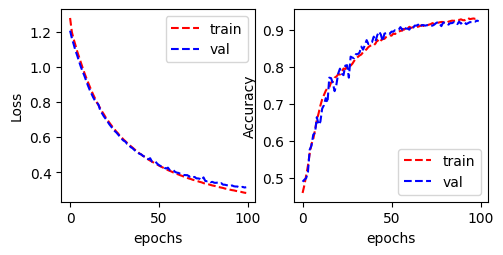

In [17]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

* From the loss and accuracy graph above, we can see that the model is able to generalise well on unseen data.
* The model is neither overfitting nor underfitting based on the above graph.
* The accuracy of both the training and validation sets is high (over 90%).
* No drop out and regularisation is needed as the model is not overfitting.

In [18]:
test_data['ShapeClass'] = test_data['ShapeClass'].astype('str')

test_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_shape = test_datagen_shape.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImgPath",
        y_col="ShapeClass",
        target_size=(28, 28),
        batch_size=batch_size,
        shuffle = False,
        color_mode='grayscale', # Make it greyscale
        class_mode='categorical')

Found 740 validated image filenames belonging to 5 classes.


In [19]:
model.evaluate(test_generator_shape) # Test Data

740/740 [==============================] - 4s 6ms/step - loss: 0.3693 - categorical_accuracy: 0.8892


[0.36926642060279846, 0.8891891837120056]

In [20]:
import numpy as np
predictions = model.predict_generator(test_generator_shape) # Predict the test data
predicted_classes = np.argmax(predictions, axis=1) # Select the index with the highest score

true_classes = test_generator_shape.classes
class_labels = list(test_generator_shape.class_indices.keys())  

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\4133445273.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator_shape)


In [21]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     diamond       0.98      0.74      0.84        69
         hex       0.00      0.00      0.00        14
       round       0.88      0.94      0.91       340
      square       0.93      0.90      0.92       138
    triangle       0.86      0.92      0.89       179

    accuracy                           0.89       740
   macro avg       0.73      0.70      0.71       740
weighted avg       0.88      0.89      0.88       740



C:\Users\yq_ch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yq_ch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yq_ch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* The precision, recall, f1-score of hex shape are 0, which means that the model is not able to learn the features of hex shape.
* The model correctly identified only 74% of the diamond shape, which is a little lower than round, square and triangle shapes.
* A potential problem in this model could be insufficient representation of diamond and hex instances in the training data, then the model is not able to capture the characteristics of hex and diamond shapes well.
* Overall, the model achieves high accuracy predicting testing set, with an accuracy of 0.90.

### Convolutional Nerual Network (CNN) - LeNet Architecture

* Since our baseline model is neither underfitting or overfitting based on our learning curve, we do not need to apply dropout and regularisation. Instead, we choose another architecure to improve our model.
* Without data augmentation, one possible way to improve the model is to experiment with different neural network architectures such as CNN.
* When using ANN, it might be difficult to extract features in the image than the CNN because 2-dimensional image needs to be converted to 1-dimensional vector as input.
* CNNs are designed to process image data because the convolution in CNNs is effective in detecting features in an image and learning the features.
* There are several network architectures for image classification task, but we will try the LeNet architecture for classifying shape classes.
* Our image size is small (28x28x1) so we do not need to try out complex architecture like VGG first. 
* Instead, LeNet could be a better choice in our case due to its relatively simpler architecture, and less computational resources is required.
* Our LeNet Architecture is very simple, it consists of one Input layer, one convolutional block, one flattening later and dense layers. 
* ReLu activations were used in all the layers except the output layer which uses Softmax activation.


In [46]:
model_leNet_shape = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax')
])


In [47]:
model_leNet_shape.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_leNet_shape = model_leNet_shape.fit_generator(train_generator_shape, 
                                    validation_data = validation_generator_shape, 
                                    epochs=25, verbose=0)

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\2378177628.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_leNet_shape = model_leNet_shape.fit_generator(train_generator_shape,


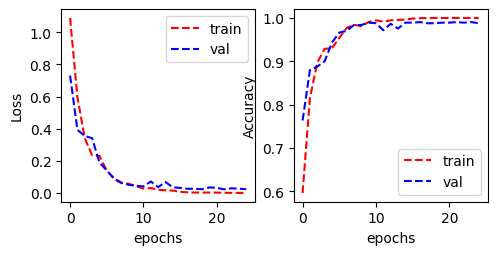

In [48]:
plot_learning_curve(history_leNet_shape.history['loss'], history_leNet_shape.history['val_loss'], 
                    history_leNet_shape.history['categorical_accuracy'], history_leNet_shape.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

* From the loss and accuracy graph above, we can see that the model is able to generalise well on unseen data because the training and validation curves follow each other closely.
* The model is neither overfitting nor underfitting based on the above graph.
* The accuracy of both the training and validation sets is extremely high (over 95%).
* We do not need to apply drop out and regularisation as the model is not overfitting.

In [49]:
model_leNet_shape.evaluate(test_generator_shape)

740/740 [==============================] - 2s 3ms/step - loss: 0.0594 - categorical_accuracy: 0.9892


[0.05944520980119705, 0.9891892075538635]

In [50]:
shape_label_names = {'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}

In [51]:
predictions = model_leNet_shape.predict_generator(test_generator_shape) # Predict the test data
predicted_classes = np.argmax(predictions, axis=1) # Select the index with the highest score

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\700624522.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_leNet_shape.predict_generator(test_generator_shape)


In [52]:
true_classes = test_generator_shape.classes
class_labels = list(test_generator_shape.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     diamond       0.98      0.94      0.96        69
         hex       1.00      1.00      1.00        14
       round       0.99      0.99      0.99       340
      square       0.99      1.00      1.00       138
    triangle       0.98      0.99      0.98       179

    accuracy                           0.99       740
   macro avg       0.99      0.98      0.99       740
weighted avg       0.99      0.99      0.99       740



* From the above evaluation metrics, we can see that our precision, recall and f1-score of the hex shape have improved significally compared to our baseline model.
* This implies that our model can generalise well on unseen data, and even on imbalanced classes.
* This model can capture the features of each shape accurately, as can be seen from their f1-score.
* This model has extremely high accuracy of 99%, which means it can correctly classify 99% of the shapes in the training set.

#### Shape class prediction

* We are statisfied with the accuracy of our shape classification model, so we can visualize the output of our network.

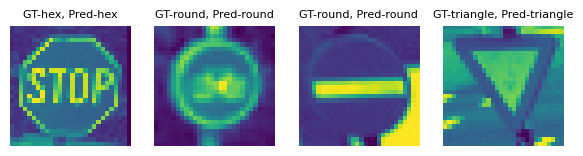

In [40]:
d_inv = {v: k for k, v in shape_label_names.items()}
plt.figure(figsize=(9,5))
batches = 0
for x,y in test_generator_shape:
        batches = batches + 1
        y_hat = model_leNet_shape.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ), fontsize=8)
            
        else:
            break
        
        plt.axis('off')

### Independent Dataset Evaluation - Shape Class

In [137]:
test_datagen_shape_ind = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_shape_ind = test_datagen_shape_ind.flow_from_dataframe(
        dataframe=trafficsigns_test,
        directory='./',
        x_col="ImgPath",
        y_col="ShapeClass",
        target_size=(28, 28),
        batch_size=batch_size,
        shuffle = False,
        color_mode='grayscale',
        class_mode='categorical')

Found 446 validated image filenames belonging to 5 classes.


C:\Users\yq_ch\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="ImgPath". These filename(s) will be ignored.
  warnings.warn(


In [54]:
model_leNet_shape.evaluate(test_generator_shape_ind) # Independent Test Data

446/446 [==============================] - 1s 3ms/step - loss: 0.8954 - categorical_accuracy: 0.8251


[0.8954477310180664, 0.8251121044158936]

In [55]:
predictions = model_leNet_shape.predict_generator(test_generator_shape_ind) # Predict the test data
predicted_classes = np.argmax(predictions, axis=1) # Select the index with the highest score
true_classes = test_generator_shape_ind.classes
class_labels = list(test_generator_shape_ind.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\1570624250.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_leNet_shape.predict_generator(test_generator_shape_ind)


              precision    recall  f1-score   support

     diamond       0.85      0.85      0.85        46
         hex       1.00      0.67      0.80        24
       round       0.89      0.83      0.86       228
      square       0.67      0.79      0.72        63
    triangle       0.77      0.86      0.81        85

    accuracy                           0.83       446
   macro avg       0.83      0.80      0.81       446
weighted avg       0.84      0.83      0.83       446



#### Independent dataset Shape class prediction

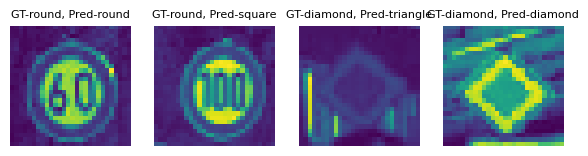

In [74]:
d_inv = {v: k for k, v in shape_label_names.items()}
plt.figure(figsize=(9,10))
batches = 0
for x,y in test_generator_shape_ind:
        batches = batches + 1
        y_hat = model_leNet_shape.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ), fontsize=8)
        else:
            break
        
        plt.axis('off')

* As can be seen from the classification accuracy above, our independent dataset still achieves a high accuracy, over 80%. However, it is not as high as the accuracy we observed from the original test set.
* We have lots of images in our dataset where the traffic signs are far away from the camera. We zoomed in or cropped them out manually to extract the traffic signs, but this often leads to lower image quality. Despite this, humans are still able to recognize the shape and type of the traffic signs in the images.
* If most of the training data are in high quality, the CNN might have overfit to the high-quality train images, making it difficult for the model to generalize well to the unseen and diverse test images (which the brightness, angle and the quality differ from the training data).
* The accuracy of the test data may be decreased if our test data consists of some low quality images that are not represented well in the training data.

### Convolutional Nerual Network (CNN) - VGG Architecture

* From the evaluation matrices above,  we can see that there is still room for improvement.
* The LeNet architecture is very simple and useful for predicting traffic sign shapes, we will try a more complex architecture to see if the performance of the model improves when predicting our independent dataset.
* In the VGG structure, we have input layer, 4 convolutional blocks with increasing filter numbers (32, 64, 128, 256), one flattening layer and dense layers.
* All the activation functions in this VGG structure are 'relu' function.

In [15]:
model_VGG_shape = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
])

In [16]:
model_VGG_shape.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [17]:
model_VGG_shape.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                 

In [219]:
history_VGG_shape = model_VGG_shape.fit_generator(train_generator_shape, validation_data = validation_generator_shape, epochs=25, verbose=0)

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\1216459610.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_shape = model_VGG_shape.fit_generator(train_generator_shape, validation_data = validation_generator_shape, epochs=25, verbose=0)


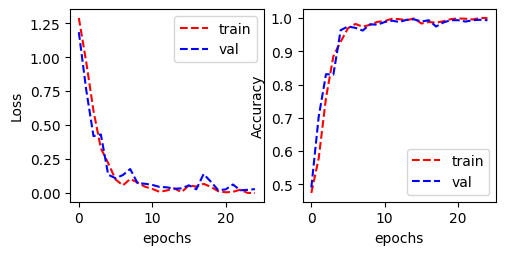

In [220]:
plot_learning_curve(history_VGG_shape.history['loss'], history_VGG_shape.history['val_loss'], 
                    history_VGG_shape.history['categorical_accuracy'], history_VGG_shape.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [221]:
model_VGG_shape.evaluate(test_generator_shape_ind)

446/446 [==============================] - 3s 7ms/step - loss: 1.1183 - categorical_accuracy: 0.8655


[1.1182715892791748, 0.865470826625824]

In [222]:
predictions = model_VGG_shape.predict_generator(test_generator_shape_ind) # Predict the test data
predicted_classes = np.argmax(predictions, axis=1) # Select the index with the highest score
true_classes = test_generator_shape_ind.classes
class_labels = list(test_generator_shape_ind.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\3530484127.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG_shape.predict_generator(test_generator_shape_ind)


              precision    recall  f1-score   support

     diamond       1.00      0.74      0.85        46
         hex       0.95      0.88      0.91        24
       round       0.88      0.93      0.90       228
      square       0.76      0.76      0.76        63
    triangle       0.84      0.84      0.84        85

    accuracy                           0.87       446
   macro avg       0.89      0.83      0.85       446
weighted avg       0.87      0.87      0.86       446



* From Figure 13 above, we can see that there is a significant increase in accuracy of our CNN model when predicting our independent dataset.
* This implies that the complex VGG architecture is able to learn the underlying traffic sign shapes more effectively. Therefore, we will select this model as the final model to predict the traffic sign shapes.

In [223]:
model_VGG_shape.save("model_VGG_shape")

INFO:tensorflow:Assets written to: model_VGG_shape\assets


INFO:tensorflow:Assets written to: model_VGG_shape\assets


## Type Classification

### Baseline Model - Convolutional Nerual Network (CNN)

* Based on the previous justification, we find that CNN is more suitable for image classification tasks in our case.
* Our current method for classifying traffic signs (using a CNN model) works well because it's great at recognizing the shapes of the signs. Therefore, we'll stick with this approach for now.
* The Type class has more than 10 classes, it might be a little difficult for simple architecture model to learn its complex features. Therefore, we will use a sophisticated architecture (e.g., VGG) in this case.
* Since we have a smaller image, we will use only 4 VGG blocks to construct the network.
* In the VGG structure, we have input layer, 4 convolutional blocks with increasing filter numbers (32, 64, 128, 256), one flattening layer and dense layers.
* All the activation functions in this VGG structure are 'relu' function.

In [96]:
train_datagen_type = ImageDataGenerator(rescale=1./255)
val_datagen_type = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator_type = train_datagen_type.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="TypeClass",
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

validation_generator_type = val_datagen_type.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="TypeClass",
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [175]:
model_VGG_type = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE),
])

In [176]:
model_VGG_type.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [177]:
history_VGG_type = model_VGG_type.fit_generator(train_generator_type, validation_data = validation_generator_type, epochs=25, verbose=0)

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\4072310332.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_type = model_VGG_type.fit_generator(train_generator_type, validation_data = validation_generator_type, epochs=25, verbose=0)


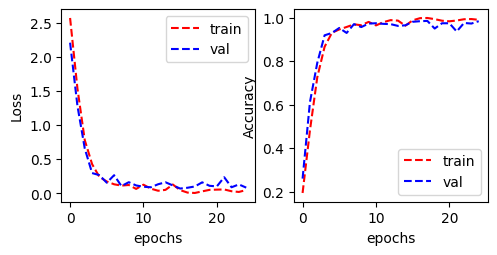

In [157]:
plot_learning_curve(history_VGG_type.history['loss'], history_VGG_type.history['val_loss'], 
                    history_VGG_type.history['categorical_accuracy'], history_VGG_type.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

* The learning curve looks similar to our CNN model that is used to classify traffic sign shape.
* From the loss and accuracy graph above, we can see that the model is able to generalise well on unseen data because the training and validation curves follow each other closely.
* Same as the previous model, the model is neither overfitting nor underfitting based on the above graph, so we do not need to apply drop out and regularisation.
* The accuracy of both the training and validation sets is extremely high (over 95%).

In [146]:
test_datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_type = test_datagen_type.flow_from_dataframe(
    dataframe=test_data,
    directory='./',
    x_col="ImgPath",
    y_col="TypeClass",
    target_size=(28, 28),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle = False,
    class_mode='categorical')

Found 740 validated image filenames belonging to 16 classes.


In [158]:
model_VGG_type.evaluate(test_generator_type)

740/740 [==============================] - 6s 8ms/step - loss: 0.0826 - categorical_accuracy: 0.9838


[0.08257388323545456, 0.9837837815284729]

In [103]:
type_label_names = {'bicycle': 0,
 'continue': 1,
 'crossing': 2,
 'giveway': 3,
 'laneend': 4,
 'limitedtraffic': 5,
 'noentry': 6,
 'noparking': 7,
 'parking': 8,
 'rightofway': 9,
 'roundabout': 10,
 'speed': 11,
 'stop': 12,
 'trafficdirective': 13,
 'traveldirection': 14,
 'warning': 15}

In [159]:
predictions = model_VGG_type.predict_generator(test_generator_type) # Predict the test data
predicted_classes = np.argmax(predictions, axis=1) # Select the index with the highest score 

true_classes = test_generator_type.classes
class_labels = list(test_generator_type.class_indices.keys())  

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\1970508498.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG_type.predict_generator(test_generator_type)


In [160]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

         bicycle       0.98      1.00      0.99        65
        continue       1.00      0.98      0.99        46
        crossing       1.00      1.00      1.00        23
         giveway       1.00      0.96      0.98        47
         laneend       0.94      1.00      0.97        17
  limitedtraffic       0.90      1.00      0.95        18
         noentry       0.99      0.97      0.98        76
       noparking       0.92      0.98      0.95        48
         parking       0.98      1.00      0.99        52
      rightofway       1.00      0.96      0.98        69
      roundabout       1.00      0.94      0.97        16
           speed       1.00      1.00      1.00        58
            stop       1.00      1.00      1.00        14
trafficdirective       1.00      0.97      0.99        38
 traveldirection       0.91      0.95      0.93        21
         warning       1.00      1.00      1.00       132

        accu

* From the above evaluation metrics, we can see that all our precision, recall and f1-score are above 0.90.
* This indicates that our CNN model can perform well on our training set, and even on imbalanced classes.
* This model can learn the features of each type accurately and it has extremely high accuracy of 98%, which means it can correctly classify 98% of the traffic sign types in the training set.

### Regularisation and Dropout

* We will try to add regularisation and dropout to our CNN model to see if our previous justifications that the model is not overfitting are correct.
* We apply lambda = 0.001 and drop out = 0.2 to see if the performance of the model improves.

In [161]:
reg_lambda = 0.001

model_VGG_type_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE),
])

In [162]:
model_VGG_type_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [163]:
history_VGG_type_2 = model_VGG_type_2.fit_generator(train_generator_type, validation_data = validation_generator_type, epochs=25, verbose=0)

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\3295244673.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_type_2 = model_VGG_type_2.fit_generator(train_generator_type, validation_data = validation_generator_type, epochs=25, verbose=0)


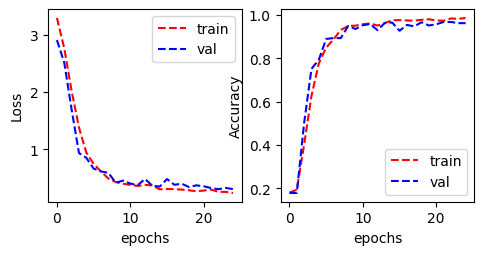

In [165]:
plot_learning_curve(history_VGG_type_2.history['loss'], history_VGG_type_2.history['val_loss'], 
                    history_VGG_type_2.history['categorical_accuracy'], history_VGG_type_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [166]:
model_VGG_type_2.evaluate(test_generator_type)

740/740 [==============================] - 6s 8ms/step - loss: 0.3082 - categorical_accuracy: 0.9703


[0.30815786123275757, 0.9702702760696411]

* From the above output, we can see that the accuracy has decreased, but the validation accuracy and loss is closer to training accuracy and loss.
* Thus, we can conclude that our previous justification for not having regularization and drop out is correct.

#### Type class prediction

* We are statisfied with the accuracy of our type classification model, so we can visualize the output of our network.

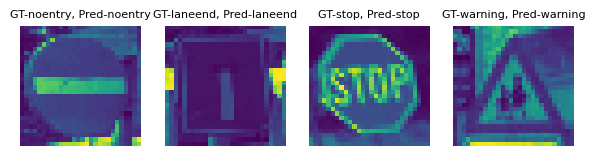

In [167]:
d_inv = {v: k for k, v in type_label_names.items()}
plt.figure(figsize=(9,5))
batches = 0
for x,y in test_generator_type:
        batches = batches + 1
        y_hat = model_VGG_type.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)   
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ), fontsize=8)
        else:
            break
        
        plt.axis('off')

### Independent Dataset Evaluation - Type Class

In [182]:
test_datagen_type_ind = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_type_ind = test_datagen_type_ind.flow_from_dataframe(
        dataframe=trafficsigns_test,
        directory='./',
        x_col="ImgPath",
        y_col="TypeClass",
        target_size=(28, 28),
        batch_size=batch_size,
        shuffle = False,
        color_mode='grayscale',
        class_mode='categorical')

Found 446 validated image filenames belonging to 16 classes.


C:\Users\yq_ch\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="ImgPath". These filename(s) will be ignored.
  warnings.warn(


In [178]:
model_VGG_type.evaluate(test_generator_type_ind) # Independent Dataset Test

446/446 [==============================] - 4s 8ms/step - loss: 1.8142 - categorical_accuracy: 0.6502


[1.814168930053711, 0.6502242088317871]

In [179]:
predictions = model_VGG_type.predict_generator(test_generator_type_ind)
predicted_classes = np.argmax(predictions, axis=1)

C:\Users\yq_ch\AppData\Local\Temp\ipykernel_14388\841353316.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG_type.predict_generator(test_generator_type_ind)


In [180]:
true_classes = test_generator_type_ind.classes
class_labels = list(test_generator_type_ind.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

         bicycle       0.10      0.25      0.14         8
        continue       0.00      0.00      0.00         1
        crossing       0.80      0.53      0.64        15
         giveway       1.00      1.00      1.00        23
         laneend       0.75      0.80      0.77        15
  limitedtraffic       0.65      0.83      0.73        18
         noentry       0.93      0.62      0.74        21
       noparking       0.62      0.80      0.70        10
         parking       0.75      0.66      0.70        32
      rightofway       0.83      0.85      0.84        46
      roundabout       0.60      0.82      0.69        11
           speed       0.95      0.37      0.53        97
            stop       0.37      0.83      0.51        24
trafficdirective       0.32      0.59      0.42        17
 traveldirection       0.52      0.26      0.35        46
         warning       0.74      1.00      0.85        62

        accu

#### Independent dataset Type class prediction

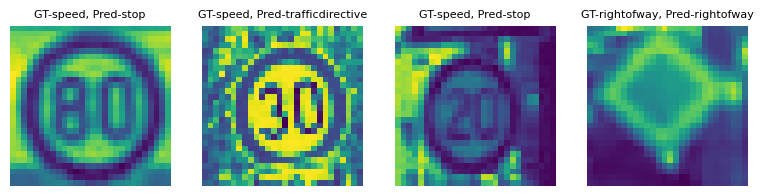

In [207]:
d_inv = {v: k for k, v in type_label_names.items()}
plt.figure(figsize=(12,5))
batches = 0
for x,y in test_generator_type_ind:
        batches = batches + 1
        y_hat = model_VGG_type.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ), fontsize=8)
        else:
            break
        
        plt.axis('off')

* The speed-sign type in the original dataset has examples of signs of speeds only from 10 - 70 mph. The model is not able to generalise well on signs of speeds with higher than 70 mph in our independent dataset.
* Overall, the model was unable to classify some traffic sign types, such as bicycle and continue signs, as can be seen from their low f1 scores.
* The training set is not diversified enough as there are some traffic signs are not included, making the model difficult to classify the traffic sign accurately.
* Therefore, we can say that the original training dataset does not have enough samples to represent the population well.

In [224]:
model_VGG_type.save("model_VGG_type")

INFO:tensorflow:Assets written to: model_VGG_type\assets


INFO:tensorflow:Assets written to: model_VGG_type\assets


## Conclusion

* In conclusion, CNN is better than ANN in image classification, and both our CNN models achieve very high accuracy of over 98%.
* Classification of traffic sign types is usually more difficult than classification of traffic sign shapes. A single traffic sign type may contain different patterns, such as a warning sign type, which makes it difficult for the model to learn its underlying patterns.
* Even though the model performs well on the original dataset, it does not generalize well on our independent dataset containing unseen and diverse test images.
* One of possible solutions is to gather additional training data that are more diverse than the original data (not allowed in this assignment). For example, we can include low-quality images and add more examples so that the model can learn all types of signs that can represent the population well.
* Another possible solution is to try data augmentation, where we randomly perturb the original dataset to form a larger dataset and use that for training. (not allowed in this assignment). 
* We also noticed that some images in the original dataset are duplicated, this may lead to data leakage and overfitting issues, making the model difficult to generalise well on unseen data.

## References

Traore, M. (2022). german-traffic-sign-detection-benchmark_dataset [dataset]. https://universe.roboflow.com/mohamed-traore-2ekkp/gtsdb---german-traffic-sign-detection-benchmark/dataset/1?ref=roboflow2huggingface